In [205]:
import numpy as np
import matplotlib.pyplot as plt
import fastf1.plotting
import itertools as it

In [ ]:
# Credit to dialtone for the code to detect corners - very handy!
# Made using the fastf1 library

In [206]:
fastf1.Cache.enable_cache('cache')

fastf1.plotting.setup_mpl()

session = fastf1.get_session(2022, 1, 'R')
session.load()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']


In [207]:
# Telemetry

teams = []
podiums = []
colors = []
telemetry = []

session_results = session.results

# Get podium drivers and teams
for i in range(0,3):
    driver = session_results.iloc[i, 2]
    team = session.results.iloc[i, 3]
    podiums.append(driver)
    teams.append(team)

for driver in podiums: 
    fastest_lap = session.laps.pick_driver(driver).pick_fastest()

    # Use padding so that there are values outside of the desired range for accurate interpolation later
    car_data = fastest_lap.get_car_data(pad=1, pad_side='both')
    pos_data = fastest_lap.get_pos_data(pad=1, pad_side='both')

    merged_data = car_data.merge_channels(pos_data)

    # Slice again to remove the padding and interpolate the exact first and last value
    merged_data = merged_data.slice_by_lap(fastest_lap, interpolate_edges=True)

    telemetry.append(merged_data.add_distance())

In [208]:
# Credit to dialtone for the corner detection : https://gist.github.com/dialtone/e2483183d807285b531c19c72d443b21

# Detect the corners 

def find_corners(tel):
    corners = []
    tel.reset_index()
    corner_cnt = 1
    in_corner = False
    start, end = None, None

    for _, row in tel.iterrows():
        if (row['CurrentAction'] == 'Cornering') and not in_corner:
            in_corner = True
            s = int(row['Distance'])
            if not start or start > s:
                start = s

        if (row['CurrentAction'] == 'Full Throttle') and in_corner:
            in_corner = False
            corner_cnt += 1
            corners.append((start, int(row['Distance'])))
            start = None
    return corners


corners_by_car = []
# Decorate telemetry with driver action
for tel in telemetry:
    tel.loc[tel['Brake'] > 0, 'CurrentAction'] = 'Cornering'
    tel.loc[tel['Throttle'] > 97, 'CurrentAction'] = 'Full Throttle'
    tel.loc[(tel['Brake'] == 0) & (tel['Throttle'] < 97), 'CurrentAction'] = 'Cornering'

    # find corners for lap
    corners_by_car.append(find_corners(tel))

def overlap(og, corner):
    (start1, end1) = og
    (start2, end2) = corner
    return end1 >= start2 and end2 >= start1

"""
different telemetries could have a different set of corners
we put them all together, remove duplicates and then extend a corner
if different cars create overlapping corners.
"""

def merge_corners(corners_by_car):
    c = sorted(set(it.chain(*corners_by_car)))
    newc = []
    singles = []
    i = 0
    while i < len(c):
        # somehow in saudi arabia this is needed to remove something bad from the data
        if c[i] == (612, 619):
            i += 1
            continue
        if singles == []:
            singles.append(c[i])
            i += 1
            continue

        if any(overlap(s, c[i]) for s in singles):
            singles.append(c[i])
        else:
            corn = (min(s[0] for s in singles), max(s[1] for s in singles))
            newc.append(corn)
            singles = [c[i]]

        i += 1

    if singles:
        newc.append((min(s[0] for s in singles), max(s[1] for s in singles)))

    return newc

corners = merge_corners(corners_by_car)

In [209]:
# Credit to dialtone for the corner detection : https://gist.github.com/dialtone/e2483183d807285b531c19c72d443b21

def mini_pro(stream):
    # Ensure that all samples are interpolated
    dstream_start = stream[1] - stream[0]
    dstream_end = stream[-1] - stream[-2]
    return np.concatenate([[stream[0] - dstream_start], stream, [stream[-1] + dstream_end]])

all_tels = []
for tel in telemetry:
    all_tels.extend(tel['Distance'].tolist())
distances = np.array(sorted(set(all_tels)))
fully_interpolated_laps = []
for i, ref in enumerate(telemetry):
    ltime = mini_pro(ref['Time'].dt.total_seconds().to_numpy())
    ldistance = mini_pro(ref['Distance'].to_numpy())
    lap_time = np.interp(distances, ldistance, ltime)

    fully_interpolated_laps.append(lap_time)

"""
Now calculate the speeds by corner as well as the center of the corner
it also calculates the time, but that isn't displayed because it's broken
"""

speeds_by_corner = []
corner_loc = []
for corner in corners:
    speed_by_driver = []
    loc_by_driver = []
    for tel, interp_lap in zip(telemetry, fully_interpolated_laps):
        corner_speeds = tel['Speed'].loc[
                (tel['Distance'] >= corner[0]) & (tel['Distance'] <= corner[1])
            ]
        corner_time_min = interp_lap[distances.searchsorted(corner[0])]
        corner_time_max = interp_lap[distances.searchsorted(corner[1])]

        speed_by_driver.append((corner_speeds.min(), corner_speeds.mean(), corner_time_max-corner_time_min))
        loc = tel['Distance'].loc[(tel['Speed'] == speed_by_driver[-1][0]) & (tel['Distance'] >= corner[0]) & (tel['Distance'] <= corner[1])]
        loc_by_driver.append(
            loc.mean()
        )

    speeds_by_corner.append(speed_by_driver)
    corner_loc.append(sum(loc_by_driver)/len(loc_by_driver))

(560, 870) 715.0
(1359, 1595) 1477.0
(1750, 2059) 1904.5
(2094, 2314) 2204.0
(2524, 2780) 2652.0
(3282, 3490) 3386.0
(3735, 3827) 3781.0
(3931, 4148) 4039.5
(4724, 4937) 4830.5


C:\Users\Adam.Lowe\AppData\Local\Programs\Python\Python39\lib\site-packages\fastf1\events.py:634: FutureWarning: The `Weekend.name` property is deprecated and will beremoved in a future version.
Use `Event['EventName']` or `Event.EventName` instead.
  warnings.warn(


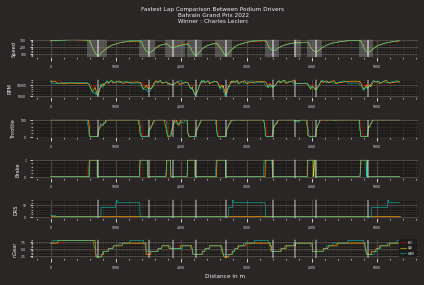

In [210]:
# Plot everything

for team in teams:
    colors.append(fastf1.plotting.team_color(team))

metrics = ['Speed', 'RPM', 'Throttle', 'Brake', 'DRS', 'nGear']

fig, axs = plt.subplots(len(metrics))

for corner in corners:
    print(corner, (corner[0]+corner[1])/2)

for i, ax in enumerate(axs):
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(3)

    for label in ax.yaxis.get_ticklabels():
        label.set_fontsize(3)

    metric = metrics[i]
    ax.set_ylabel(metric, size=5)

    if metric == 'Speed':
        for corner in corners:
            ax.axvspan(corner[0], corner[1], color='gray', alpha=0.5, lw=0)

    for j, driver in enumerate(podiums):
        color = colors[j]
        tel = telemetry[j]

        if driver == 'SAI':
            ax.plot(tel['Distance'], tel[metric], linewidth=0.5, color='#F7EA00', label=driver)
            for xc in corner_loc:
                ax.axvline(x=int(xc), linewidth=0.3, color="white")
        else:
            ax.plot(tel['Distance'], tel[metric], linewidth=0.5, color=color, label=driver)
            for xc in corner_loc:
                ax.axvline(x=int(xc), linewidth=0.3, color="white")

ax = axs[0]
ax.set_xlim(axs[1].get_xlim())
for xc in corner_loc:
    ax.axvline(x=int(xc), linewidth=0.3, color="white")

ax = axs[-1]
ax.xaxis.set_visible(True)
ax.legend(loc=4, fontsize=3)
ax.set_xlabel('Distance in m', size='xx-small')
plt.suptitle(f"Fastest Lap Comparison Between Podium Drivers\n "
             f"{session.event.name} {session.event.year}\n "
             f"Winner : {session_results.iloc[0, 7]}", size='xx-small')
plt.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.08)
plt.tight_layout()
plt.savefig(f"images/{session.event.name}.png", dpi=600)
plt.show()